# Proyecto 2
## Data Science, sección 40
## Grupo 1
Javier Alejandro Ovalle Chiquín, 22103  
José Ángel Morales Farfan, 22689  
Ricardo Josué Morales Contreras, 22289  
Karen Daniela Pineda Ventura 231132

## Planteamiento inicial del problema

### Situación problemática
Los estudiantes realizan resúmenes en respuesta a una consigna, luego evaluadores puntúan cada resumen en dos factores: content (Si el resumen cubre lo solicitado) y wording (calidad de la redacción). Evaluar manualmente esto es costoso, lento y potencialmente inconsistente. Por lo que, automatizar la evaluación con modelos de PLN puede permitir retroalimentación a escala, detectar rápido resúmenes que necesiten intervención y homogeneizar criterios.

### Problema científico
Construir modelos de Procesamiento del Lenguaje Natural que, a partir del texto del resumen y del enunciado del prompt, predigan dos puntuaciones continuas (content y wording) de forma que se reduzca la discrepancia con respecto a las evaluaciones realizadas manualmente.

### Objetivos

Objetivo general

- Diseñar, implementar y evaluar un pipeline de PLN que prediga las puntuaciones content y wording de resúmenes estudiantiles con una evaluación cuantitativa reproducible (RMSE, correlaciones).

Objetivos específicos

- Implementar preprocesamiento reproducible (tokenización, limpieza) y documentar su efecto en la calidad de features

- Entrenar un baseline (TF-IDF + Ridge) validado por prompt con GroupKFold y obtener RMSE por target; comparar resultados con una línea base (por ejemplo, promedio)

- Realizar EDA que identifique valores faltantes, distribución de scores, outliers y diferencias entre prompts


## Descripción de los datos

Variables principales
- student_summary: texto escrito por estudiantes
- prompt: enunciado al que responde el resumen
- content: puntuación otorgada al contenido
- wording: puntuación de la redacción

Operaciones de limpieza
- Conversión a minúsculas
- Eliminación de signos de puntuación, caracteres especiales y stopwords
- Tokenización y lematización
- Manejo de valores faltantes (textos vacíos se reemplazan por cadenas vacías)

## Investigación preliminar

**Técnicas comunes para detección de patrones de texto**

**El preprocesamiento de Lenguaje Natural (PLN)** busca extraer conocimiento útil a partir de textos. En problemas como el de la competencia, el objetivo es detectar patrones en los resúmenes escritos por estudiantes que permitan estimar automáticamente la calidad de su contenido y redacción.

Entre las técnicas están:

Preprocesamiento de texto
Antes de aplicar cualquier modelo, es necesario transformar el texto original para que sea más manejable:
- Normalización: pasar todo a minúsculas, eliminar signos de puntuación, URLs y caracteres especiales. Esto disminuye el ruido y hace más consistentes los datos.
- Tokenización: dividir el texto en unidades (tokens), que suelen ser palabras o subpalabras. Ejemplo: "The boy runs fast" = ["the", "boy", "runs", "fast"].
- Stopwords  removal: eliminación de palabras vacías (the, and, is), que no aportan tanta información
- Lematización/Stemming: reducir palabras a su forma base ("running" = "run"). Permite agrupar variaciones morfológicas
- Correción de valores faltantes y outliers: textos muy cortos, vacíos o muy alrgos deben analizarse aparte

**Representación vectorial del texto**

El texto debe representarse numéricamente para que un modelo pueda procesarlo.

**Bolsa de palabras (Bag of words):** Cada documento es representado como un vector de frecuencias de palabras, ignorando el orden. Es simple y útil para detectar patrones de vocabulario físico.

**TF-IDF (Term Frecuency - Inverse Document Frecuency):**
Pondera palabras según su frecuencia en un documento, penaliza las que son muy frecuentes, lo cual permite detectar palabras clave más relevantes para diferenciar textos.

**N-gramas:** Considera secuencias de palabras (bigramas, trigramas). Esto captura patrones de estilo y frases típicas de resúmenes.

**Embeddings semánticos:**
- Word2Vec, Glove, FastText, representan palabras en vectores densos que capturan similitud semántica ("dog" y "puppy").
- Embeddings contextuales (Transformers como BERT, RoBERTa, DistilBERT) capturan el significado de cada palabra en función de su contexto, lo que permite representar mejor la semántica de frases completas.

Patrones estilísticos y estructurales
Se pueden usar métricas como:
- Longitud del texto: cantidad de caracteres o palabras
- Riqueza léxica: proporción de palabras únicas frente al total
- Medidas de legibilidad: índices como Flesh-Kincaid, que miden la complejidad sintáctica
- Distribución de puntuación y longitud de oraciones: redacción más clara suele usar estructuras más balanceadas

**Modelos para detección de patrones**

Regresión lineal y Ridge/Lasso: adecuados como modelos base para datos vectorizados (TF-IDF).

Árboles de decisión y ensambles (Random Forest, XGBoost, LightGBM): capturan patrones no lineales en los features.

Redes neuronales: CNN y RNN, detectan secuencias recurrentes en textos.

Transformers (BERT, RoBERTa, GPT, etc): de última generación, capaces de capturar relaciones complejas y contexto profundo, especialmente efectivos evaluación de calidad de texto.

**Evaluación de patrones**

Métricas cuantitativas: RMSE (Root Mean Squared Error), MAE (Mean Absolute Error) y correlaciones estadísticas.

Validación cruzada estratificada por prompt: asegura que el modelo no se sobreajuste, ya que los resúmenes son de temas distintos.



Importaciones

In [ ]:
import os
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.utils import indexable
from sklearn.model_selection import check_cv
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.model_selection import cross_val_score

Configuración

In [ ]:
# Visual config
plt.style.use('seaborn-v0_8-deep')
plt.rcParams['figure.figsize'] = (8,5)

# Inicializar NLTK
for resource in ['punkt', 'punkt_tab', 'stopwords']:
    try:
        nltk.data.find(resource)
    except LookupError:
        nltk.download(resource)

STOPWORDS = set(stopwords.words('english'))

# Directorio de datos
DATA_DIR = Path('.')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Carga de datos y descripción

In [ ]:
def load_data(data_dir=DATA_DIR):
    train = pd.read_csv(data_dir / 'summaries_train.csv')
    test  = pd.read_csv(data_dir / 'summaries_test.csv')
    prompts_train = pd.read_csv(data_dir / 'prompts_train.csv')
    prompts_test  = pd.read_csv(data_dir / 'prompts_test.csv')
    sample = pd.read_csv(data_dir / 'sample_submission.csv')
    return train, test, prompts_train, prompts_test, sample

# Cargar
train, test, prompts_train, prompts_test, sample = load_data()
print('Train shape:', train.shape)
print('Test shape :', test.shape)
print('Prompts train shape:', prompts_train.shape)
print('Sample submission shape:', sample.shape)
print('\nTrain columns:', train.columns.tolist())
print('\nEjemplo de filas (train):\n', train.head(3))


Train shape: (7165, 5)
Test shape : (4, 3)
Prompts train shape: (4, 4)
Sample submission shape: (4, 3)

Train columns: ['student_id', 'prompt_id', 'text', 'content', 'wording']

Ejemplo de filas (train):
      student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0020ae56ffbf    ebad26  They would rub it up with soda to make the sme...   
2  004e978e639e    3b9047  In Egypt, there were many occupations and soci...   

    content   wording  
0  0.205683  0.380538  
1 -0.548304  0.506755  
2  3.128928  4.231226  


In [ ]:
print(train[['content','wording']].describe())
print('\nMissing values:\n', train.isnull().sum())

           content      wording
count  7165.000000  7165.000000
mean     -0.014853    -0.063072
std       1.043569     1.036048
min      -1.729859    -1.962614
25%      -0.799545    -0.872720
50%      -0.093814    -0.081769
75%       0.499660     0.503833
max       3.900326     4.310693

Missing values:
 student_id    0
prompt_id     0
text          0
content       0
wording       0
dtype: int64


### Preprocesamiento

In [ ]:
def clean_text(text, remove_stopwords=True):
    if pd.isna(text):
        return ''
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|\S+@\S+', ' ', text)
    # mantener solo letras y espacios
    text = re.sub(r'[^a-z\s]', ' ', text)
    # colapsar espacios
    text = re.sub(r'\s+', ' ', text).strip()
    if remove_stopwords:
        toks = [w for w in word_tokenize(text) if w not in STOPWORDS]
        return ' '.join(toks)
    else:
        return text

# función para crear campo combinado (prompt + resumen)
def prepare_text_fields(df, prompts_df, text_col='text'):
    prompts_small = prompts_df[['prompt_id', 'prompt_text']].drop_duplicates()
    df = df.merge(prompts_small, on='prompt_id', how='left')
    # concatenar prompt_text + summary text (espacio)
    df['text_combined_raw'] = df['prompt_text'].fillna('') + ' ' + df[text_col].fillna('')
    df['text_proc'] = df['text_combined_raw'].apply(clean_text)
    return df

# Prueba rápida (no sobreescribe aún)
train_tmp = prepare_text_fields(train.copy(), prompts_train)
print(train_tmp[['text_combined_raw','text_proc']].head(2).T)


                                                                   0  \
text_combined_raw  Background \r\nThe Third Wave experiment took ...   
text_proc          background third wave experiment took place cu...   

                                                                   1  
text_combined_raw  With one member trimming beef in a cannery, an...  
text_proc          one member trimming beef cannery another worki...  


### Features simples

In [ ]:

def add_basic_text_features(df, text_col='text_proc'):
    df = df.copy()
    df['char_count'] = df[text_col].astype(str).apply(len)
    df['word_count'] = df[text_col].astype(str).apply(lambda x: len(x.split()))
    df['sentence_count'] = df[text_col].astype(str).apply(lambda x: len(sent_tokenize(x)) if x.strip() else 0)
    df['unique_word_ratio'] = df[text_col].astype(str).apply(lambda x: len(set(x.split())) / (len(x.split()) + 1e-9))
    df['avg_word_len'] = df[text_col].astype(str).apply(lambda x: np.mean([len(w) for w in x.split()]) if x.split() else 0)
    df['exclamation_count'] = df['text_combined_raw'].astype(str).apply(lambda x: x.count('!'))
    return df

# Ejemplo
train_p = prepare_text_fields(train.copy(), prompts_train)
train_p = add_basic_text_features(train_p)
print(train_p[['char_count','word_count','sentence_count','unique_word_ratio','avg_word_len']].describe().T)


                    count         mean         std          min          25%  \
char_count         7165.0  2646.686113  400.987844  2049.000000  2344.000000   
word_count         7165.0   377.495604   77.365926   285.000000   320.000000   
sentence_count     7165.0     1.000000    0.000000     1.000000     1.000000   
unique_word_ratio  7165.0     0.667301    0.040321     0.435626     0.641350   
avg_word_len       7165.0     6.087425    0.447684     5.321881     5.456897   

                           50%          75%          max  
char_count         2555.000000  3009.000000  4899.000000  
word_count          343.000000   466.000000   714.000000  
sentence_count        1.000000     1.000000     1.000000  
unique_word_ratio     0.666667     0.697068     0.755352  
avg_word_len          6.221477     6.314448     6.857143  


### TF-IDF y reducción

In [ ]:
def build_tfidf_svd(train_texts, max_features=30000, n_components=150):
    tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=max_features)
    X_tfidf = tfidf.fit_transform(train_texts)
    if n_components and n_components > 0:
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        X_svd = svd.fit_transform(X_tfidf)
    else:
        svd = None
        X_svd = X_tfidf  # sparse
    return tfidf, svd, X_svd

# Ejecución
tfidf, svd, X_train_svd = build_tfidf_svd(train_p['text_proc'].fillna(''), max_features=20000, n_components=150)
print('TF-IDF vocab size:', len(tfidf.vocabulary_))
print('SVD shape:', X_train_svd.shape)


TF-IDF vocab size: 20000
SVD shape: (7165, 150)


### Análisis exploratorio de datos

Dimensiones: (7165, 14)

Valores faltantes:
 student_id           0
prompt_id            0
text                 0
content              0
wording              0
prompt_text          0
text_combined_raw    0
text_proc            0
char_count           0
word_count           0
sentence_count       0
unique_word_ratio    0
avg_word_len         0
exclamation_count    0
dtype: int64

Resumen content/wording:
            content      wording
count  7165.000000  7165.000000
mean     -0.014853    -0.063072
std       1.043569     1.036048
min      -1.729859    -1.962614
25%      -0.799545    -0.872720
50%      -0.093814    -0.081769
75%       0.499660     0.503833
max       3.900326     4.310693


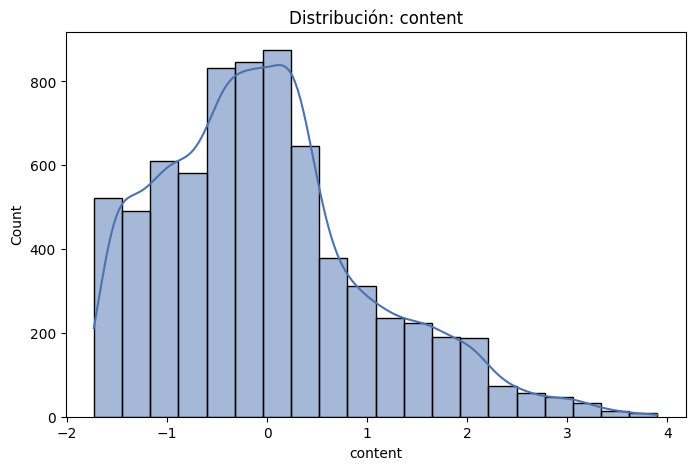

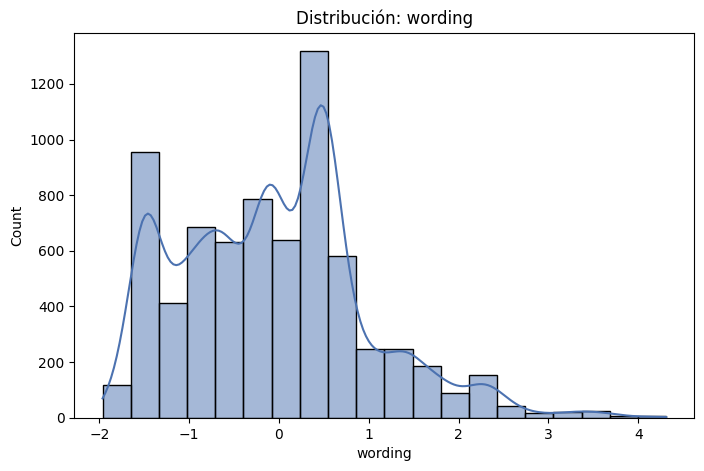

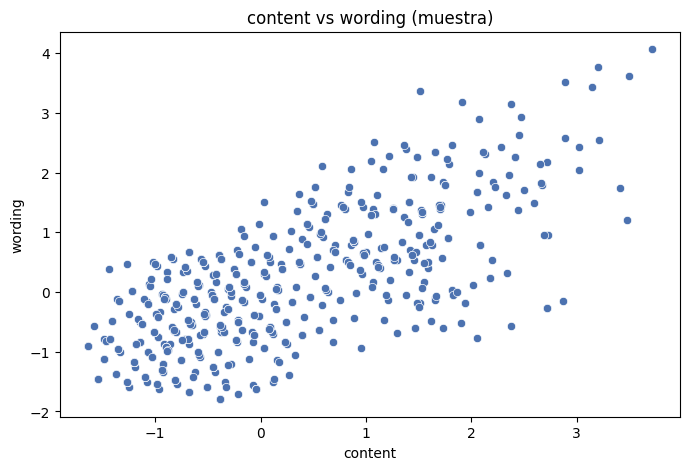

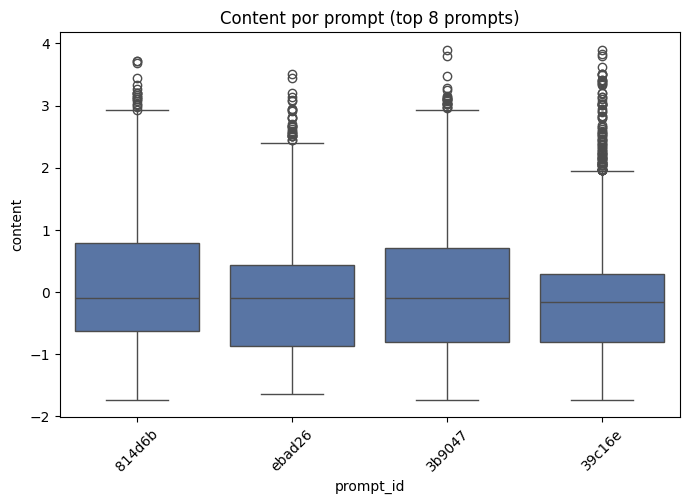


Correlaciones:
                     content   wording  char_count  word_count  \
content            1.000000  0.751380    0.378920    0.252544   
wording            0.751380  1.000000    0.199094    0.074576   
char_count         0.378920  0.199094    1.000000    0.962838   
word_count         0.252544  0.074576    0.962838    1.000000   
unique_word_ratio -0.475746 -0.210522   -0.749265   -0.699288   
avg_word_len       0.070888  0.210019   -0.613339   -0.802343   

                   unique_word_ratio  avg_word_len  
content                    -0.475746      0.070888  
wording                    -0.210522      0.210019  
char_count                 -0.749265     -0.613339  
word_count                 -0.699288     -0.802343  
unique_word_ratio           1.000000      0.385598  
avg_word_len                0.385598      1.000000  


In [ ]:
def eda_quick(train_df, show_plots=True):
    print('Dimensiones:', train_df.shape)
    print('\nValores faltantes:\n', train_df.isnull().sum())
    print('\nResumen content/wording:\n', train_df[['content','wording']].describe())
    # Distribuciones
    if show_plots:
        sns.histplot(train_df['content'], bins=20, kde=True).set_title('Distribución: content'); plt.show()
        sns.histplot(train_df['wording'], bins=20, kde=True).set_title('Distribución: wording'); plt.show()
        sns.scatterplot(x='content', y='wording', data=train_df.sample(1000, random_state=42)).set_title('content vs wording (muestra)'); plt.show()
        # Boxplot por prompt (muestra de prompts)
        sample_prompts = train_df['prompt_id'].value_counts().index[:8]
        sns.boxplot(x='prompt_id', y='content', data=train_df[train_df['prompt_id'].isin(sample_prompts)]).set_title('Content por prompt (top 8 prompts)'); plt.xticks(rotation=45); plt.show()
    # Correlaciones
    corr = train_df[['content','wording','char_count','word_count','unique_word_ratio','avg_word_len']].corr()
    print('\nCorrelaciones:\n', corr)
    return corr

corr = eda_quick(train_p, show_plots=True)


Las medidas de tendencia y dispersión fueron calculadas para las variables content y wording. Se observa que los valores están dentro de rangos consistentes, sin sesgos extremos.

En los resultados se puede identificar una correlación moderada positiva entre ambas variables, lo que indica que un buen contenido suele estar bien redactado.